In [1]:
import pandas as pd

df = pd.read_csv('BMI.csv')
print(df.head(10))


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   2

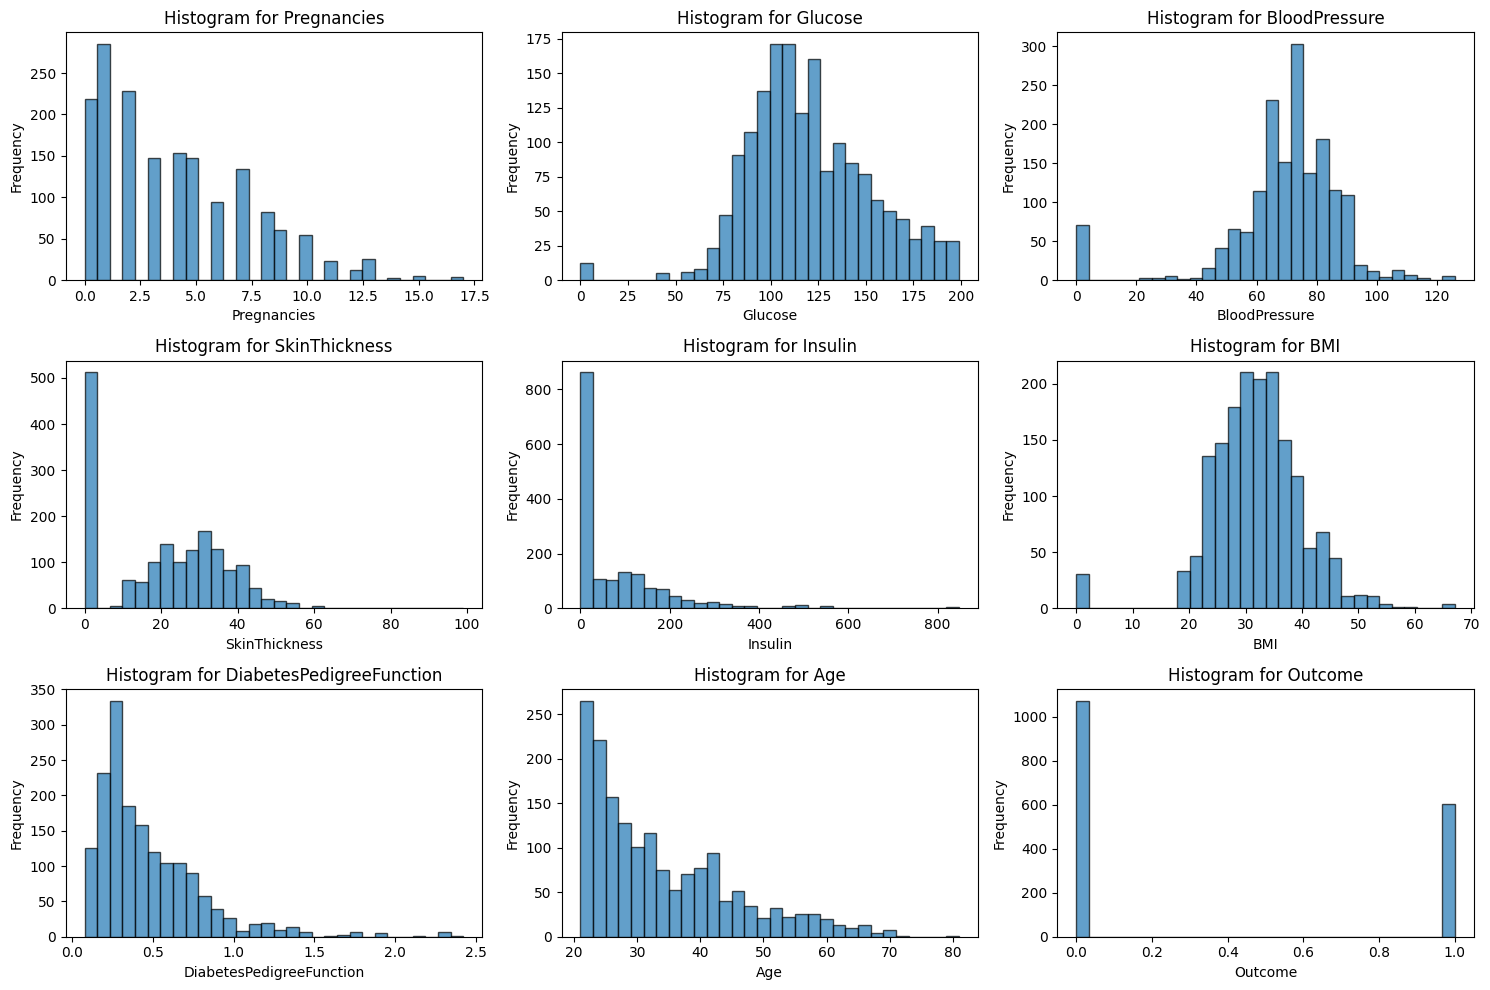

In [ ]:

import numpy as np
import matplotlib.pyplot as plt #plotting library 

# Histograms for Features 
plt.figure(figsize=(15, 10)) #size of 15 inches wide and 10 inches tall
numerical_features = df.select_dtypes(include=[np.number]).columns #selects columns in the DataFrame that have numerical data types and creates a new DataFrame containing only these numerical features.

for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()



In [ ]:
# Display missing/null values
print("\nMissing/Null values in the dataset:")
print(df.isnull().sum())

#Fill missing/null values (if any) with the column mean
#df.fillna(df.mean(), inplace=True) inplace = true modifies the original DataFrame without creating a copy.

# If duplicates exist, remove them
df.drop_duplicates(inplace=True)

# Check for duplicate rows after removal
print(f"\nNumber of duplicate rows after removal: {df.duplicated().sum()}")

#Fill 0 values except for the 'Pregnancies' and 'Outcome' columns with the median
columns_to_fill = df.columns.difference(['Pregnancies', 'Outcome'])  # Exclude 'Pregnancies' and 'Outcome' returns the column names that are not in the specified list

for column in columns_to_fill:
    df[column] = df[column].replace(0, df[column].median())  # Replace 0s with median in remaining columns





Missing/Null values in the dataset:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Number of duplicate rows after removal: 0


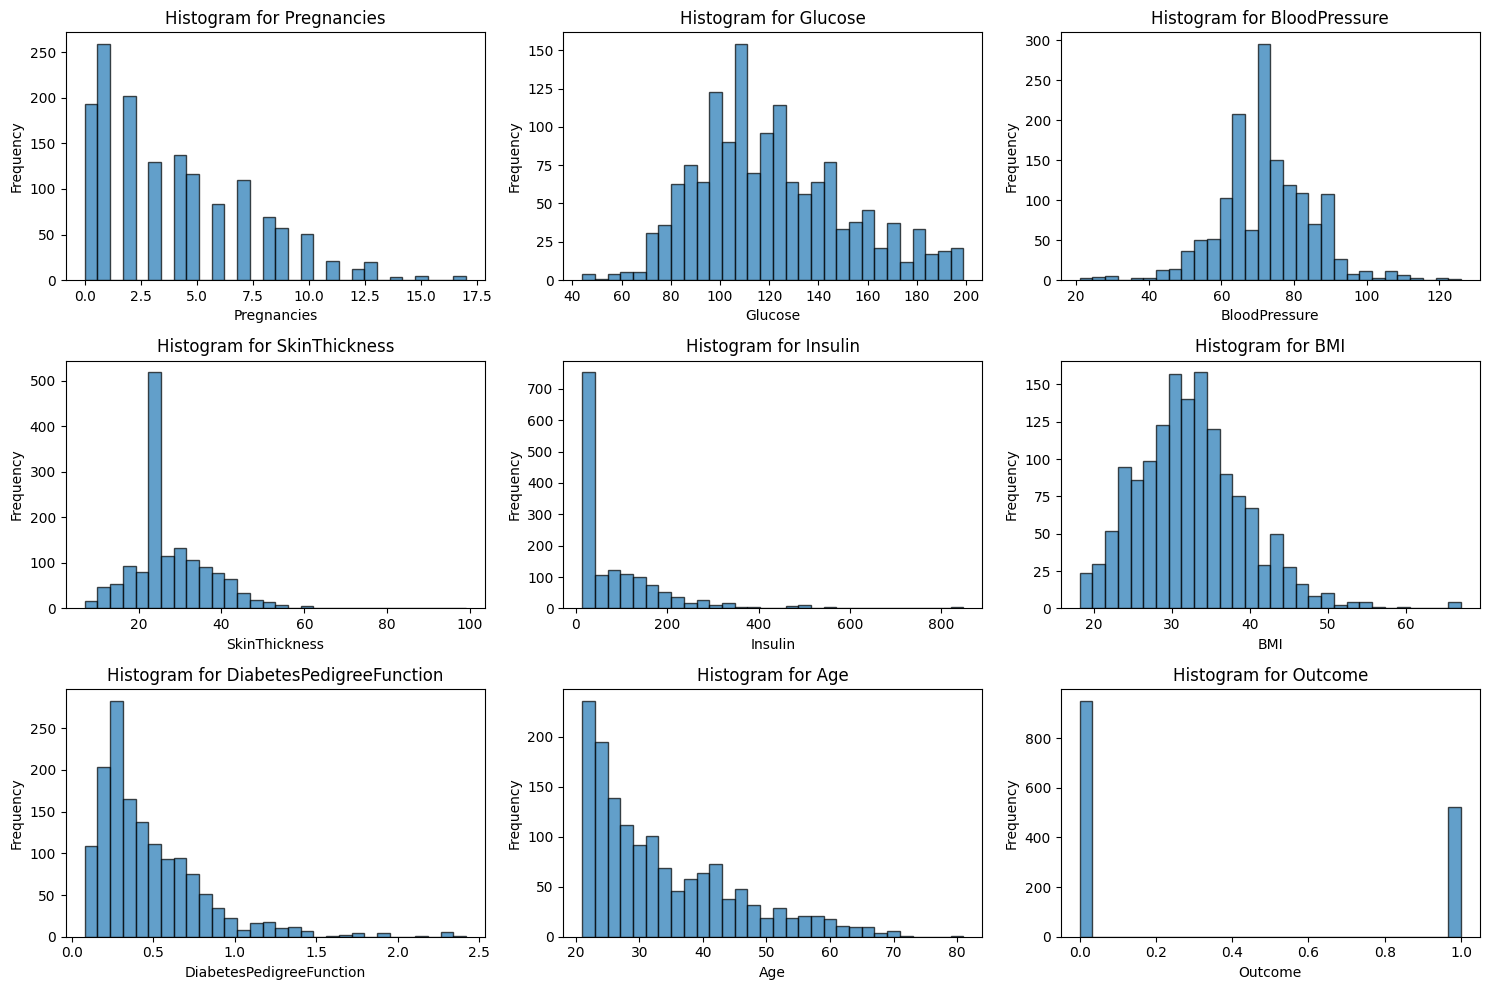

In [4]:
import matplotlib.pyplot as plt


#Display Histograms for Numerical Features After Filling Missing Values and Zero Replacements
plt.figure(figsize=(15, 10))
numerical_features = df.select_dtypes(include=[np.number]).columns #select numerical column

for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()


In [5]:
#Feature Engineering
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['BMI_Category'] = df['BMI'].apply(categorize_bmi)

def categorize_age(age):
    if age < 30:
        return 'Youth'
    elif 30 <= age < 50:
        return 'Middle-aged'
    else:
        return 'Senior'

df['Age_Group'] = df['Age'].apply(categorize_age)

#Encoding categorical variables using One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['Age_Group', 'BMI_Category'], drop_first=True) #One-Hot Encoding is a technique used to convert categorical variables into a format that can be provided to machine learning algorithms
df_encoded.reset_index(drop=True, inplace=True) #resets the index of the newly created DataFrame df_encoded after encoding.



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#Splitting the data into features (X) and target (y)
X = df_encoded.drop('BMI', axis=1)  # Drop the target column
y = df_encoded['BMI']  # Change target to BMI

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Linear Regression model training
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

#Random Forest model training with Grid Search CV
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [20, 40, 60],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest parameters from Grid Search:", grid_search.best_params_)

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Model Evaluation
print("\nRandom Forest Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_best_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_best_rf))
print("R²:", r2_score(y_test, y_pred_best_rf))

# Performance comparison for Linear Regression
y_pred_linear = linear_model.predict(X_test)
print("\nLinear Regression Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_linear))
print("MAE:", mean_absolute_error(y_test, y_pred_linear))
print("R²:", r2_score(y_test, y_pred_linear))


Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters from Grid Search: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}

Random Forest Performance:
MSE: 7.152315395002615
MAE: 1.5905331664815654
R²: 0.8477138464060657

Linear Regression Performance:
MSE: 15.895125025390925
MAE: 3.0094211315804857
R²: 0.6615630998735359


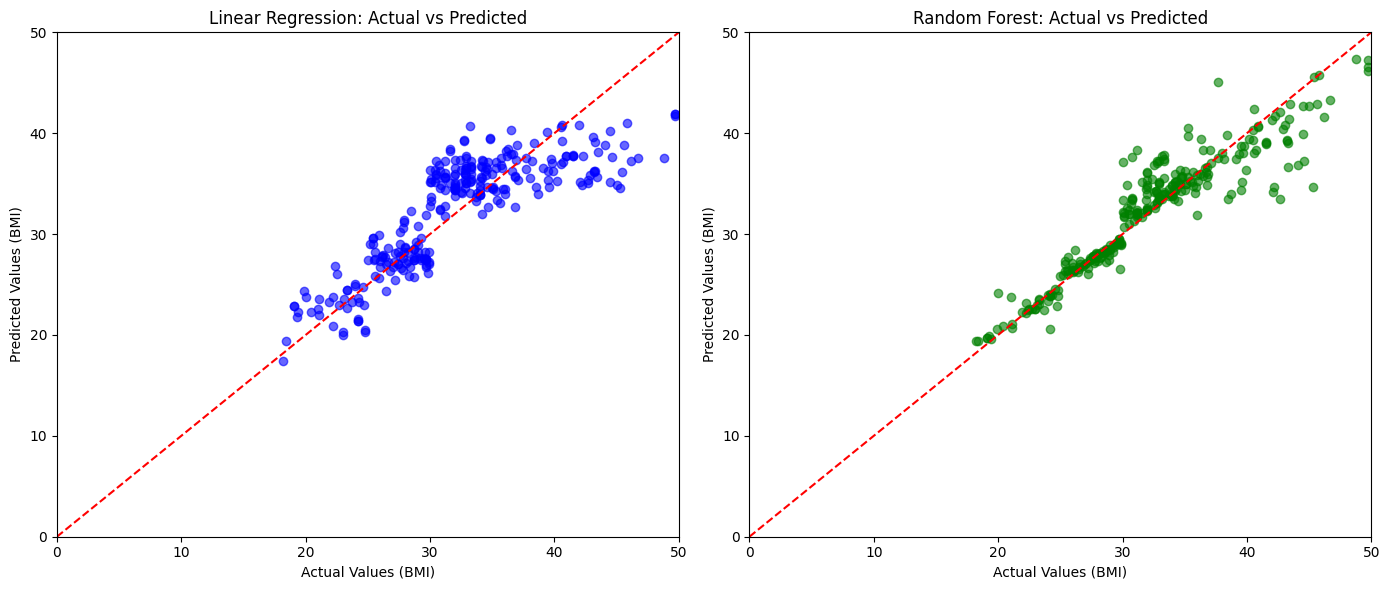

In [7]:
import matplotlib.pyplot as plt
# Plotting Actual vs Predicted for Linear Regression
plt.figure(figsize=(14, 6))

# Subplot for Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')  # Line y=x for reference
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values (BMI)')
plt.ylabel('Predicted Values (BMI)')
plt.xlim([0, 50])
plt.ylim([0, 50])

# Plotting Actual vs Predicted for Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_best_rf, color='green', alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')  # Line y=x for reference
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Values (BMI)')
plt.ylabel('Predicted Values (BMI)')
plt.xlim([0, 50])
plt.ylim([0, 50])

plt.tight_layout()
plt.show()



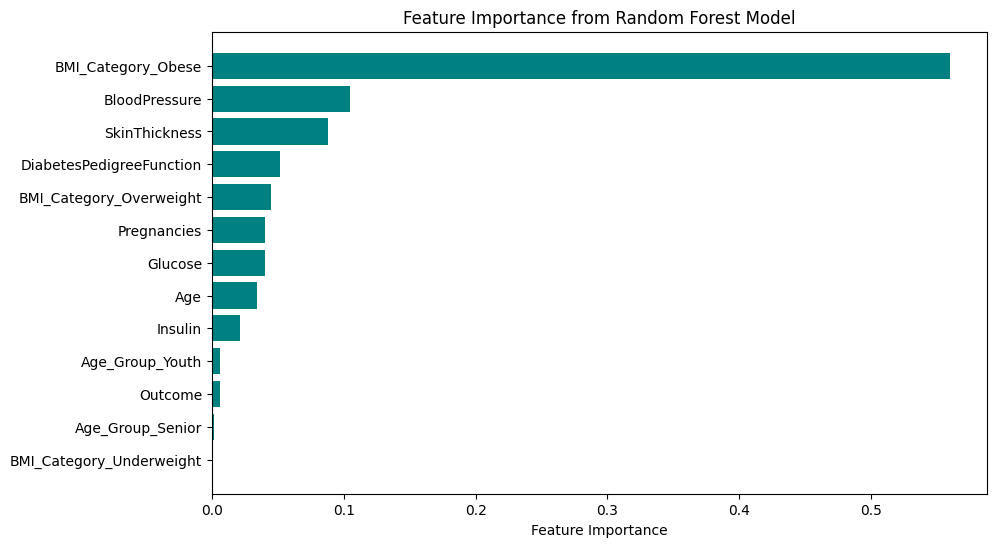

In [8]:
# Feature Importance from Random Forest
feature_importances = best_rf.feature_importances_
features = X.columns  # Get the feature names from the original dataset before scaling

# Sort the feature importances in descending order and plot
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], feature_importances[sorted_idx], color='teal') # Creates a horizontal bar plot for feature importance.
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature on top
plt.show()